# PyTorch CIFAR10 

Building a simple classifier in PyTorch. Most of the content is similar to the tensorflow version of the notebook and this notebook takes full inspiration from the pytorch tutorial.

You could also refer to the one available at <a href="https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html">PyTorch Website</a>

@date: 19-Aug-2020 | @author: Katnoria

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(tuple([0.5]*3), tuple([0.5]*3))
])

In [4]:
train_ds = datasets.CIFAR10(
    root="./data", train=True, 
    download=True, transform=transform
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)

Files already downloaded and verified


In [5]:
test_ds = datasets.CIFAR10(
    root="./data", train=False, 
    download=True, transform=transform
)

test_loader = DataLoader(test_ds, batch_size=4, shuffle=True, num_workers=2)

Files already downloaded and verified


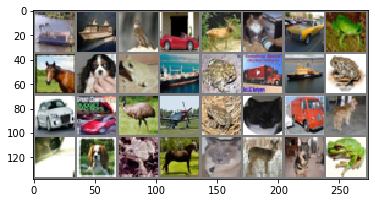

In [6]:
# Display images
images, labels = iter(train_loader).next()

# see: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(utils.make_grid(images))

# Build Model

In [48]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = self.fc3(x)
        return x
    
conv_net = SimpleConvNet()
conv_net.to(device)

SimpleConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [49]:
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_net.parameters(), lr=1e-3, momentum=0.9)

In [58]:
# Training loop
def train(epochs, net, writer):
    pbar = tqdm(range(epochs))
    for idx, epoch in enumerate(pbar):
        # set the network into training mode
        net.train()
        epoch_loss = 0
        running_corrects = 0
        for idx, record in enumerate(train_loader):
            images, labels = record
            images = images.to(device)
            labels = labels.to(device)
            # zero grad the optimizer
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                preds = net(images)
                loss = criterion(preds, labels)                
                loss.backward()
                optimizer.step()               
                # track losses
                epoch_loss += loss.item()
                _, predicted = torch.max(preds.data, 1)
                running_corrects += torch.sum(predicted == labels).item()
                
        train_loss = epoch_loss / len(train_loader)
        train_acc = running_corrects / len(train_loader)
#         print(f"{epoch}/{epochs}: train loss {train_loss:.4f}")
        pbar.set_description(f"Train Loss: {train_loss:4f} | Acc: {train_acc:.4f}")
        writer.add_scalar("loss/train", train_loss, epoch)
        writer.add_scalar("acc/train", train_acc, epoch)

In [60]:
# TRAIN
writer = SummaryWriter("runs/simple_model")
train(50, conv_net, writer)

# Better Model

In [68]:
class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 160, 3)
        self.conv3 = nn.Conv2d(160, 160, 3)
        self.conv4 = nn.Conv2d(160, 192, 3)
        self.conv5 = nn.Conv2d(192, 224, 3) 
        
        self.fc1 = nn.Linear(224 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))        
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
deep_conv_net = DeepConvNet()
deep_conv_net.to(device)

DeepConvNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(160, 192, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(192, 224, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2016, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)

In [69]:
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=0.00253)

# TRAIN
writer = SummaryWriter("runs/deep_convnet")
train(50, deep_conv_net, writer)

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size